<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Libraries-and-Data" data-toc-modified-id="Import-Libraries-and-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries and Data</a></span></li><li><span><a href="#Build-the-Function" data-toc-modified-id="Build-the-Function-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build the Function</a></span></li><li><span><a href="#Print-the-Waterfall-Plot-Individually" data-toc-modified-id="Print-the-Waterfall-Plot-Individually-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Print the Waterfall Plot Individually</a></span></li><li><span><a href="#Figure-out-which-features-affect-the-difference-between-TI-and-Shap" data-toc-modified-id="Figure-out-which-features-affect-the-difference-between-TI-and-Shap-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Figure out which features affect the difference between TI and Shap</a></span></li></ul></div>

# Import Libraries and Data

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import random
import pandas as pd
import numpy as np
import shap
import time
import pickle
from treeinterpreter import treeinterpreter as ti
path = '/Users/aubrey/Documents/SHK/Dropbox/Dingyi/Data/' #@Markus: change path to where benchmark repository, pmlb repository is stored.
save_path = '/Users/aubrey/Documents/SHK/Dropbox/Dingyi/Data/ti&shap_full/' #@Markus: change the path to where the downloaded dataset should be stored

In [5]:
# The problem is to read RData
import pyreadr
data = pyreadr.read_r(path+'SRData.RData')
# Check the comments of repo from pyreadr and you will see. 
# Relevant link: https://github.com/ofajardo/pyreadr/issues/51
# This method works on Jupyternotebook but not in colab

#!pip install rpy2
# Alternative also does not work in colab
# import rpy2.robjects as robjects
# from rpy2.robjects.conversion import localconverter
# from rpy2.robjects import pandas2ri
# load your file
# robjects.r['load']('/Users/aubrey/Documents/SHK/randomness-as-regularization/Treeinterpreter/SRData.RData')

# Using alternative only differs in the for-loop
# # retrieve the matrix that was loaded from the file
  #  with localconverter(robjects.default_converter + pandas2ri.converter):
  #      data2 = robjects.conversion.rpy2py(robjects.r[i])
  #  
  #  dict_of_df_X2["df_{}".format(i)] = data2.select_dtypes(include=np.number).iloc[:,:-1]
  #  dict_of_df_Y2["df_{}".format(i)] = data2.iloc[:,-1]
  #  X_train2 = dict_of_df_X2["df_{}".format(i)].to_numpy()
  #  Y_train2 = dict_of_df_Y2["df_{}".format(i)].to_numpy()

# Build the Function

In [6]:
def generate_ti_shap(i, data):

    X0 = data
    X1 = X0.select_dtypes(include=np.number).iloc[:,:-1] # exclude the last column (y)
    if len(X0.select_dtypes(include='category').columns) !=0: # recognize categorical feature
        X2 = pd.get_dummies(X0[(X0.select_dtypes(include='category')).columns], drop_first=True) # change it into one_hot_encoding
    else: X2 = pd.DataFrame()
    dict_of_df_X = pd.concat(objs=[X2, X1], axis=1) # combine dummies and numerical features
    
    dict_of_df_Y = data.iloc[:,-1] # the last column is y
    
    X_train = dict_of_df_X.to_numpy()
    Y_train = dict_of_df_Y.to_numpy()
    
    start_time = time.time() # record the time needed
    np.random.seed(0) # keep consistent

    print('Tuning random forest regressor based on',i) # a signal to clarify
    rf = RandomForestRegressor(random_state=0) # initial regression model

    param_grid = {'max_features': np.arange(1/6, 7/6, 1/6)} # optimize max_features, which is mtry in r

    gs_rf = GridSearchCV(rf, param_grid, cv=5, scoring='neg_root_mean_squared_error')
    gs_rf.fit(X_train, Y_train)

    print("--- %s seconds ---" % (time.time() - start_time))
    
    print("Best CV mse: %0.4f" % (-gs_rf.best_score_)) # default criterion is mse
    print("Optimal RF meta-parameters:") # check the optimal max_features
    print(gs_rf.best_params_)

    pred, bias, cfc0 = ti.predict(gs_rf.best_estimator_, X_train) # tree interpreter values
    ti_rs = pd.DataFrame(cfc0, columns = dict_of_df_X.columns) # for better plotting in r
    ti_rs.to_csv("ti_{}.csv".format(i))
    
    explainer = shap.Explainer(gs_rf.best_estimator_) # explain the model's predictions using SHAP
    shap_all = explainer(X_train)
    # Try to store the data into a .pickle file

    shap_values = pd.DataFrame(shap_all.values, columns = dict_of_df_X.columns) # store it into shap_values
    shap_values.to_csv("shap_{}.csv".format(i)) # explainer(X_train).values should be stored
    print()
    
    return gs_rf.best_params_, ti_rs, shap_all, shap_values


In [7]:
print(1/6,2/6, 3/6, 4/6, 5/6, 6/6)

0.16666666666666666 0.3333333333333333 0.5 0.6666666666666666 0.8333333333333334 1.0


In [14]:
dict_of_df_X = {} # initialize empty dictionary
dict_of_df_Y = {}
ti_rs = {}
shap_values = {}
shap_all = {}
hparam = {}

dataname = ['abalone', 'bike', 'boston', 'concrete', 'cpu', 'csm', 'fb', 'parkinsons','servo', 'solar','synthetic'] # real data

for i in dataname:
    hparam["df_{}".format(i)], ti_rs["df_{}".format(i)], shap_all["df_{}".format(i)], n = generate_ti_shap(i,data[i])
    # generate .csv file 11+11 in total


Tuning random forest regressor based on abalone
--- 26.25940728187561 seconds ---
Best CV mse: 2.1580
Optimal RF meta-parameters:
{'max_features': 0.5}

Tuning random forest regressor based on bike
--- 6.957016706466675 seconds ---
Best CV mse: 923.6366
Optimal RF meta-parameters:
{'max_features': 0.8333333333333333}

Tuning random forest regressor based on boston
--- 6.6500489711761475 seconds ---
Best CV mse: 4.1861
Optimal RF meta-parameters:
{'max_features': 0.5}

Tuning random forest regressor based on concrete
--- 8.01263689994812 seconds ---
Best CV mse: 9.6128
Optimal RF meta-parameters:
{'max_features': 0.5}

Tuning random forest regressor based on cpu
--- 4.852464914321899 seconds ---
Best CV mse: 64.7127
Optimal RF meta-parameters:
{'max_features': 0.3333333333333333}

Tuning random forest regressor based on csm
--- 4.590929269790649 seconds ---
Best CV mse: 0.8769
Optimal RF meta-parameters:
{'max_features': 0.5}

Tuning random forest regressor based on fb
--- 4.96553897857

In [7]:
# Only on simulation (additive) data 

dict_of_df_X = {} # initialize empty dictionary
dict_of_df_Y = {}
ti_rs = {}
shap_values = {}
shap_all = {}
hparam = {}

dataname = ['synthetic1','synthetic2'] # real data

for i in dataname:
    hparam["df_{}".format(i)], ti_rs["df_{}".format(i)], shap_all["df_{}".format(i)], n = generate_ti_shap(i,data[i])

Tuning random forest regressor based on synthetic1
--- 4.933434009552002 seconds ---
Best CV mse: 4.3048
Optimal RF meta-parameters:
{'max_features': 0.5}

Tuning random forest regressor based on synthetic2
--- 5.27168607711792 seconds ---
Best CV mse: 4.5181
Optimal RF meta-parameters:
{'max_features': 0.6666666666666666}



In [12]:
shap_all['df_synthetic1'].values.mean(axis = 0) # \sin(\pi X_1 X_2)

array([ 0.03552323, -0.02684945,  0.0018497 , -0.00576989, -0.01057557])

In [14]:
ti_rs['df_synthetic1'].values.mean(axis = 0) # \sin(\pi X_1 X_2)

array([ 0.01246716, -0.01541338,  0.01527424, -0.01676479, -0.0013852 ])

In [9]:
shap_all['df_synthetic2'].values.mean(axis = 0) #\sin(\pi X_1) + \sin(\pi X_2)

array([ 0.0634722 ,  0.02577306,  0.00864929, -0.02525663, -0.01067214])

In [10]:
ti_rs['df_synthetic2'].values.mean(axis = 0) #\sin(\pi X_1) + \sin(\pi X_2)

array([ 0.01670633,  0.02150757,  0.02092598, -0.00202932,  0.00485522])

In [16]:
# Seaborn visualization library
import seaborn as sns
# Create the default pairplot


In [17]:
ti_rs['df_synthetic1']

,X1,X2,X3,X4,X5
0,-3.100394,-0.286920,-3.655601,-5.123068,0.460183
1,-0.407591,1.320952,3.414263,2.454531,1.789578
2,1.570943,1.535628,-2.487680,-1.842631,2.546533
3,3.195779,2.484160,11.064251,1.878005,0.029284
4,-3.086767,-0.741409,-4.819784,-4.554150,-2.482916
...,...,...,...,...,...
495,1.481902,2.394105,4.113840,3.842489,4.346036
496,0.864656,1.673906,10.128085,-3.595560,-0.762634
497,1.738739,0.922305,9.279466,-1.064448,2.826243
498,1.250038,-2.629070,10.228824,-1.119444,-0.695277


In [ ]:
df = pd.DataFrame(ti_rs['df_synthetic1'],shap_all['df_synthetic1'])
df

In [ ]:
sns.pairplot(df)

In [11]:
# for additive synthetic
# Store best parameters in a pickle
with open(save_path+'hparam_2.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(hparam, f, pickle.HIGHEST_PROTOCOL)

 # Store shap value in a pickle
with open(save_path+'shap_all_2.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(shap_all, f, pickle.HIGHEST_PROTOCOL)
    
# Store ti_rs in a pickle
with open(save_path+'ti_rs_2.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(ti_rs, f, pickle.HIGHEST_PROTOCOL)

In [21]:
# Store best parameters in a pickle
with open(save_path+'hparam.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(hparam, f, pickle.HIGHEST_PROTOCOL)

In [18]:
# Store shap value in a pickle
with open(save_path+'shap_all.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(shap_all, f, pickle.HIGHEST_PROTOCOL)

In [2]:
# reload shap value in a pickle
with open(save_path+'shap_all.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    shap_all = pickle.load(f)


In [6]:
shap_all['df_abalone'].values.mean(axis = 0)

array([ 0.03591294,  0.00417562,  0.03719145,  0.02619267, -0.05762927,
       -0.06081895,  0.16524389,  0.09916093, -0.23376013])

In [22]:
# Store ti_rs in a pickle
with open(save_path+'ti_rs.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(ti_rs, f, pickle.HIGHEST_PROTOCOL)

In [19]:
# An overview to shap_value that I stored
shap_values['df_solar']

,class_C,class_D,class_E,class_F,class_H,largest.spot.size_H,largest.spot.size_K,largest.spot.size_R,largest.spot.size_S,largest.spot.size_X,spot.distribution_I,spot.distribution_O,spot.distribution_X,Activity,Evolution,Previous.24.hour.flare.activity.code,Historically.complex,Did.region.become.historically.complex,Area,Area.of.the.largest.spot
0,0.004653,-0.010901,-0.060001,-0.006486,-0.092337,0.001474,-0.010774,0.003427,-0.026553,0.014566,-0.016502,0.047441,-0.088245,-0.037083,-0.018533,-0.005413,0.014589,-0.010068,-0.002221,0.0
1,0.008853,0.019030,-0.044578,-0.005177,0.026105,0.002225,-0.018338,-0.055628,-0.032144,0.018977,-0.030861,-0.056461,0.020161,-0.029305,0.000684,-0.007008,0.017448,0.004013,-0.001275,0.0
2,-0.025895,-0.019094,-0.076437,-0.005752,0.028219,-0.002114,-0.018196,0.006962,0.039399,0.018512,-0.018703,-0.022541,0.020463,-0.023755,0.008337,-0.002845,-0.010475,0.002847,-0.001681,0.0
3,-0.001878,-0.004203,-0.050290,-0.008918,-0.087989,0.001260,-0.012450,-0.056997,-0.006140,0.012609,-0.031694,0.045881,-0.063960,-0.029440,-0.008716,-0.004036,0.017058,-0.008487,-0.000578,0.0
4,0.002954,-0.008861,-0.058254,-0.007327,-0.061921,0.000624,-0.012877,-0.002540,-0.022129,0.010781,-0.011659,0.040911,-0.057512,-0.029200,-0.076631,-0.004592,-0.002695,0.002566,-0.000606,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,0.002363,-0.017938,-0.050163,-0.009132,-0.070880,0.001331,-0.012057,0.007694,-0.014601,0.011932,-0.009978,0.030083,-0.058149,-0.032832,-0.008030,-0.003060,0.025124,-0.014297,-0.000668,0.0
1062,0.007696,-0.008978,-0.085375,-0.015055,-0.116628,0.001402,-0.019500,0.008852,-0.045196,0.013003,-0.027247,0.037327,-0.095255,0.081042,-0.005842,-0.004251,0.021155,-0.033855,-0.002262,0.0
1063,-0.043088,-0.032871,-0.043012,-0.011936,0.027825,0.000238,-0.023218,0.007718,0.000516,0.011073,-0.019691,-0.003401,0.022213,-0.026929,-0.032460,-0.006742,-0.043387,0.003769,-0.001601,0.0
1064,-0.003592,-0.006332,-0.051649,-0.009289,-0.089649,0.000804,-0.013196,-0.028880,-0.014095,0.013496,-0.032045,0.048015,-0.074737,-0.025275,-0.024098,-0.004092,0.015844,0.000343,-0.000541,0.0


In [32]:
ti_rs['df_abalone'] # An overview to ti that I stored

,Sex_I,Sex_M,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight
0,0.642546,0.102342,0.389868,0.527601,0.198272,0.973201,0.384294,0.083212,-0.364378
1,0.676298,0.332212,-0.031989,-0.691157,-0.980682,-0.581202,-0.095055,-0.364908,-1.046560
2,0.267182,-0.021973,-0.452167,-0.181736,-0.168318,-0.261899,0.310100,-0.000559,0.026328
3,0.346186,-0.050579,0.315865,0.272146,0.023565,-0.150298,0.082413,-0.274810,-0.567531
4,-0.279360,-0.090265,0.173695,-0.167870,-1.037281,-0.173075,-0.033658,0.040109,-1.535338
...,...,...,...,...,...,...,...,...,...
4172,0.061016,0.024082,0.100831,-0.135393,0.857290,-0.104481,0.451650,0.158338,-0.376376
4173,0.006994,-0.022436,-0.205473,0.184331,-0.043775,0.064760,-0.390428,0.340912,0.432072
4174,0.005579,-0.012087,-0.125549,0.009553,1.359692,-0.106756,-0.652054,-0.117127,-0.184294
4175,-0.004831,0.062720,-0.140800,0.053750,0.018882,0.043505,-0.586392,-0.104665,0.584788


In [33]:
print(len(ti_rs))
list(ti_rs.values())[0].shape

11


(4177, 9)

# Print the Waterfall Plot Individually

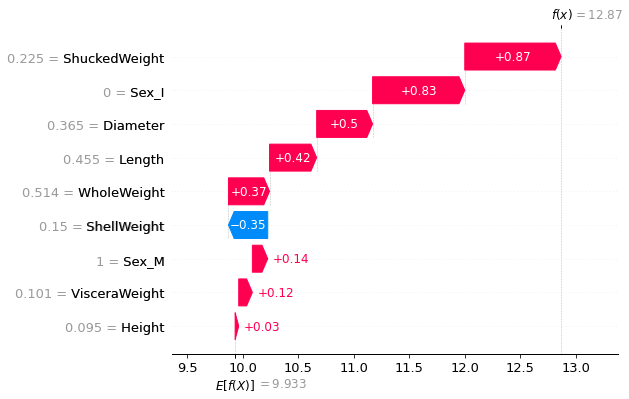

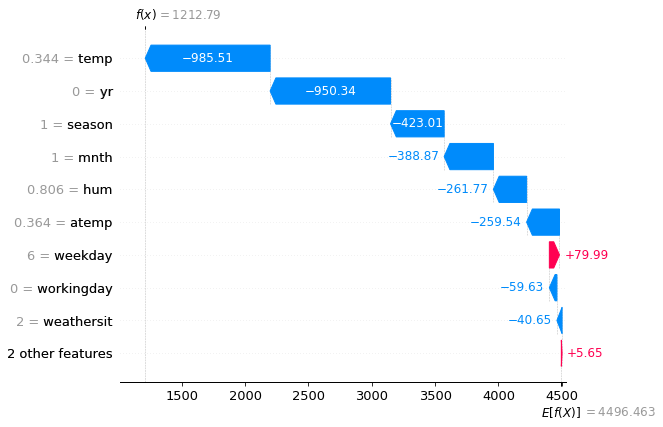

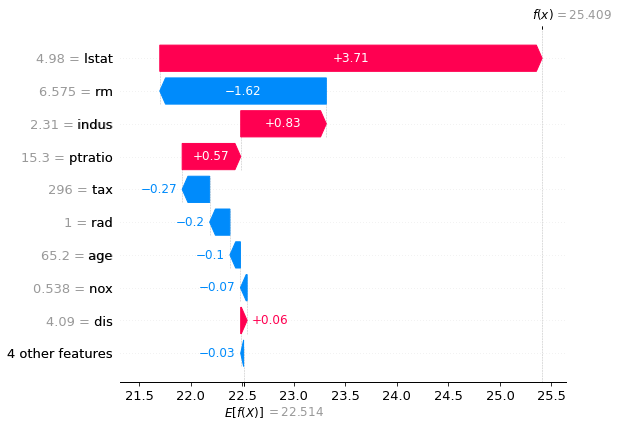

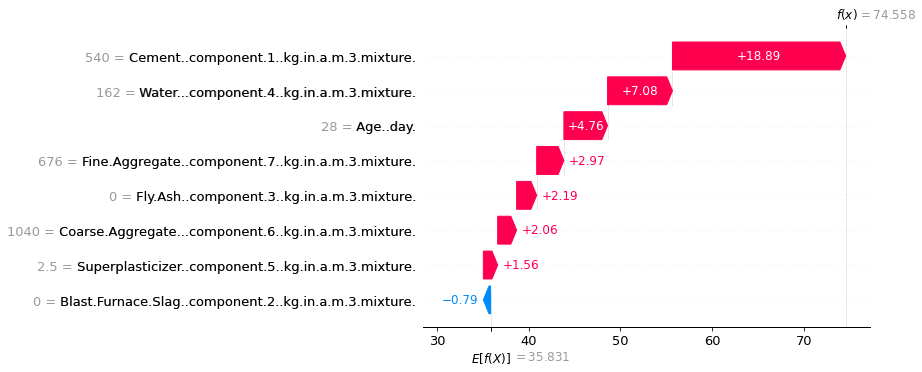

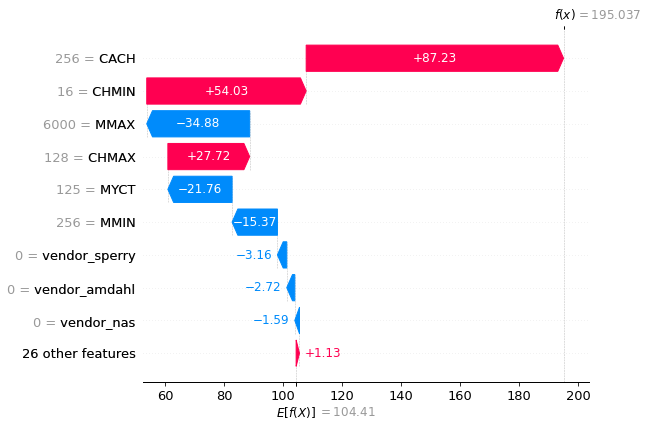

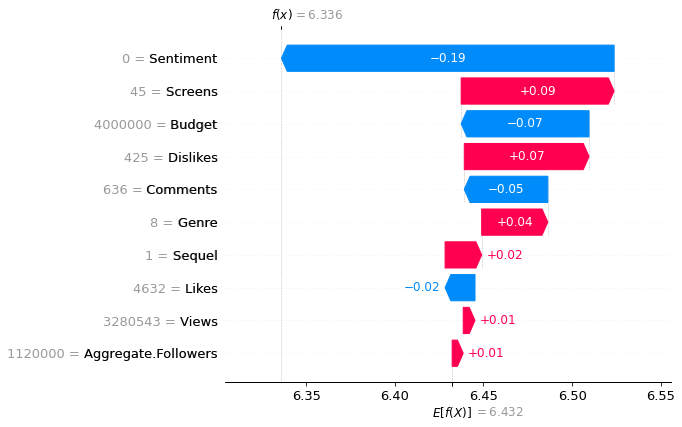

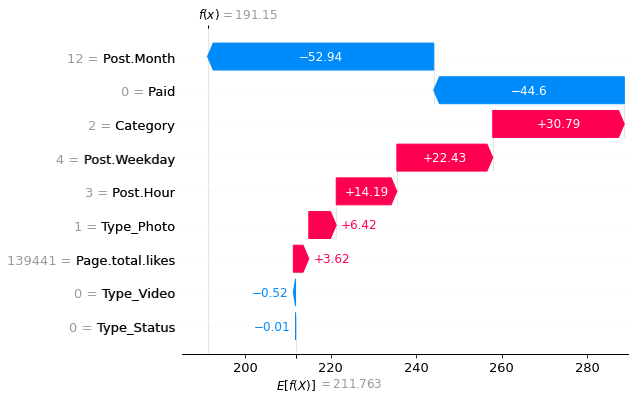

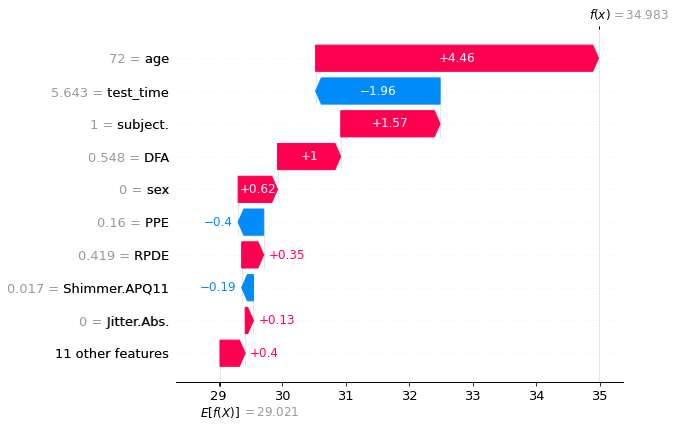

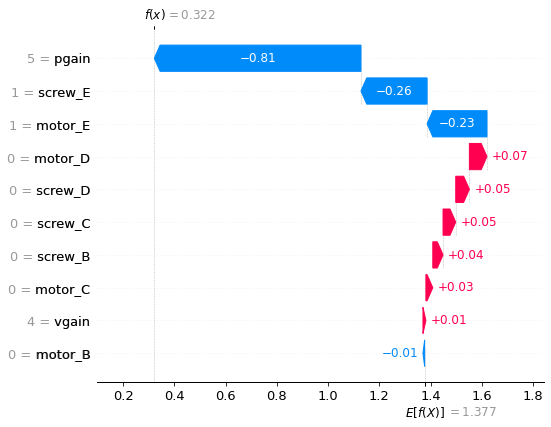

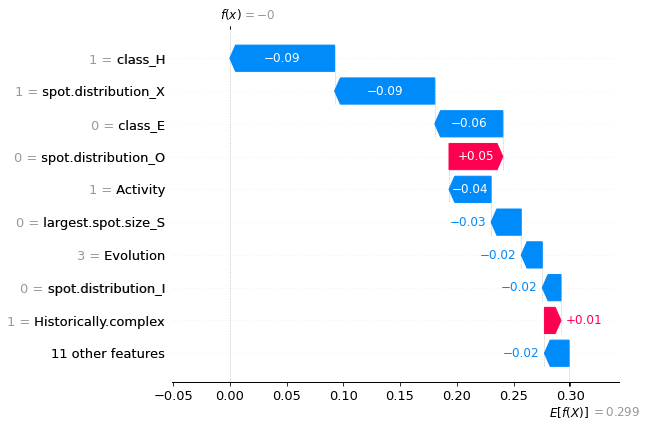

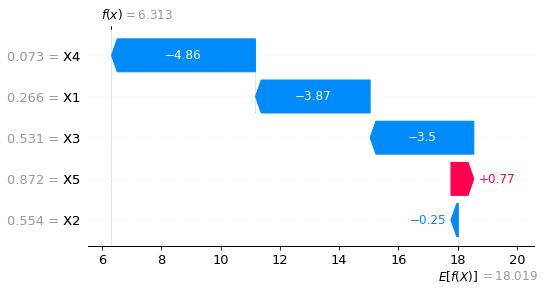

In [11]:
######Don't move this chunk, because I store explainer(X_train).values in shap_values but not the dictionary anymore
# The result cannot be duplicated unless I re-store the whole dictionary into shap_values again


# Try to print the shap
for i in dataname:

    # because of the error "'numpy.ndarray' object has no attribute 'base_values'" originated from array in .base_values
    # I rebuild it
    X0 = data[i]
    X1 = X0.select_dtypes(include=np.number).iloc[:,:-1] # exclude the last column (y)
    if len(X0.select_dtypes(include='category').columns) !=0: # recognize categorical feature
        X2 = pd.get_dummies(X0[(X0.select_dtypes(include='category')).columns], drop_first=True) # change it into one_hot_encoding
    else: X2 = pd.DataFrame()
    dict_of_df_X = pd.concat(objs=[X2, X1], axis=1) # combine dummies and numerical features
    
    shap_object = shap.Explanation(base_values = shap_values["df_{}".format(i)][0].base_values[0],
    values = shap_values["df_{}".format(i)][0].values,
    feature_names = dict_of_df_X.columns,
    data = shap_values["df_{}".format(i)][0].data)

    shap.plots.waterfall(shap_object)

# Figure out which features affect the difference between TI and Shap

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

In [22]:
ti_rs = {}
shap_values = {}

temp = pd.read_csv('ti_boston.csv',)
ti_rs['df_boston'] = temp.drop(temp.columns[0], axis=1)
temp = pd.read_csv('shap_boston.csv',)
shap_values['df_boston'] = temp.drop(temp.columns[0], axis=1)

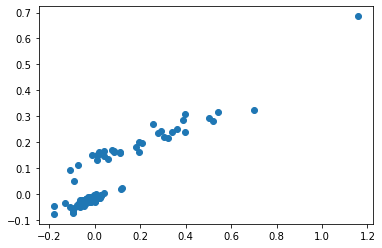

In [23]:
# Inspect which observations are obviously out of line
plt.scatter(ti_rs['df_boston']['chas'],shap_values['df_boston']['chas'])
plt.show()

In [66]:
# Select them
obs = shap_values['df_boston']['chas'][(ti_rs['df_boston']['chas'] < 0) & (shap_values['df_boston']['chas']>0)].index.values

In [64]:
# Create a function to inspect
def inspect(dataname, feature, obs):
    # Initiate loss (calculate the difference between points and ideal line constructed by correlation coefficent)
    loss = []
    
    # Because some other features are dummies, therefore the one hot encoding should be processed at first
    X0 = data[dataname]
    X1 = X0.select_dtypes(include=np.number).iloc[:,:-1] # exclude the last column (y)
    if len(X0.select_dtypes(include='category').columns) !=0: # recognize categorical feature
        X2 = pd.get_dummies(X0[(X0.select_dtypes(include='category')).columns], drop_first=True) # change it into one_hot_encoding
    else: X2 = pd.DataFrame()
    dict_of_df_X = pd.concat(objs=[X2, X1], axis=1)
    
    # Acquire other names expect for the feature that we want to analyse
    allname = list(dict_of_df_X.columns.values)
    allname.remove(feature)
    
    # A loop for calculate ti and shap when one other feature is out
    for i in allname:
        df_test = dict_of_df_X.loc[ : , dict_of_df_X.columns != i ]
        ti_rs['df_{0}_{1}'.format(dataname,i)], shap_values['df_{0}_{1}'.format(dataname,i)]= generate_ti_shap('{0}_{1}'.format(dataname,i),df_test)
        
        # Calculate pearson corr
        corr, _ = pearsonr(ti_rs['df_{0}_{1}'.format(dataname,i)][feature], shap_values['df_{0}_{1}'.format(dataname,i)][feature])
        
        # plot
        plt.scatter(ti_rs['df_{0}_{1}'.format(dataname,i)][feature][obs],shap_values['df_{0}_{1}'.format(dataname,i)][feature][obs])
        plt.xlim(min(ti_rs['df_{}'.format(dataname)][feature]), max(ti_rs['df_{}'.format(dataname)][feature]))
        plt.ylim(min(ti_rs['df_{}'.format(dataname)][feature]), max(ti_rs['df_{}'.format(dataname)][feature]))
        x = np.arange(min(ti_rs['df_{}'.format(dataname)][feature]), max(ti_rs['df_{}'.format(dataname)][feature]),0.05)
        y = corr*x
        plt.plot(x,y)
        plt.show()
        los = mean_squared_error(ti_rs['df_{0}_{1}'.format(dataname,i)][feature][obs]*corr, ti_rs['df_{0}_{1}'.format(dataname,i)][feature][obs])
        loss.append(los)
        print('without feature ',i, ' and the loss is ', los)
        print()
        
    name = np.asarray([elem for i, elem in enumerate(list(dict_of_df_X.columns.values)) if elem != feature])[loss == min(loss)]
    return name, loss

Tuning random forest regressor based on boston_crim
--- 6.067494869232178 seconds ---
Best CV mse: 4.5895
Optimal RF meta-parameters:
{'max_features': 0.9999999999999999}



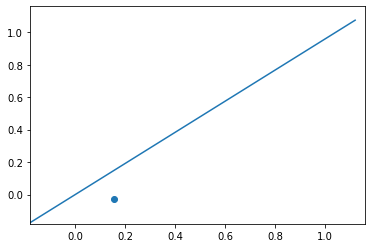

without feature  crim  and the loss is  0.000634633661396043

Tuning random forest regressor based on boston_zn
--- 6.278381109237671 seconds ---
Best CV mse: 4.5514
Optimal RF meta-parameters:
{'max_features': 0.6666666666666666}



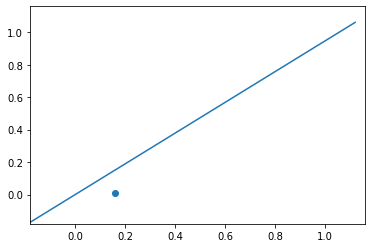

without feature  zn  and the loss is  0.0009635864803889898

Tuning random forest regressor based on boston_indus
--- 7.041678190231323 seconds ---
Best CV mse: 4.5193
Optimal RF meta-parameters:
{'max_features': 0.6666666666666666}



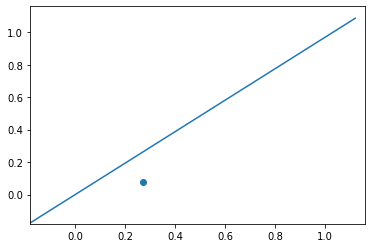

without feature  indus  and the loss is  0.00020886427506195827

Tuning random forest regressor based on boston_nox
--- 6.750612020492554 seconds ---
Best CV mse: 4.5207
Optimal RF meta-parameters:
{'max_features': 0.5}



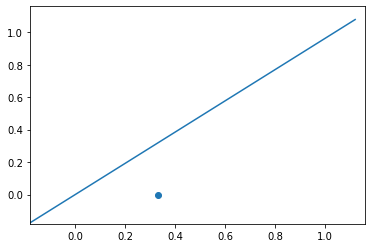

without feature  nox  and the loss is  0.00210277024049978

Tuning random forest regressor based on boston_rm
--- 6.02164626121521 seconds ---
Best CV mse: 5.4026
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



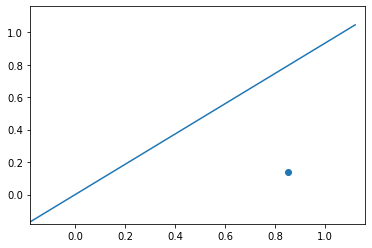

without feature  rm  and the loss is  0.01168352688358749

Tuning random forest regressor based on boston_age
--- 6.080280780792236 seconds ---
Best CV mse: 4.8673
Optimal RF meta-parameters:
{'max_features': 0.6666666666666666}



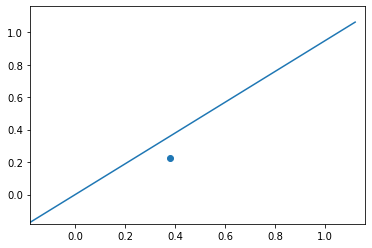

without feature  age  and the loss is  0.002551841498526807

Tuning random forest regressor based on boston_dis
--- 6.1701061725616455 seconds ---
Best CV mse: 4.4114
Optimal RF meta-parameters:
{'max_features': 0.6666666666666666}



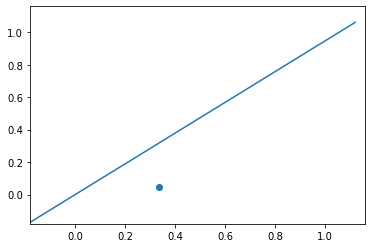

without feature  dis  and the loss is  0.00048638362813430434

Tuning random forest regressor based on boston_rad
--- 6.370355129241943 seconds ---
Best CV mse: 4.5451
Optimal RF meta-parameters:
{'max_features': 0.5}



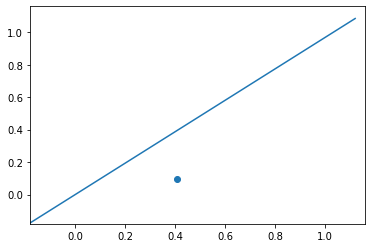

without feature  rad  and the loss is  0.0002678140641396337

Tuning random forest regressor based on boston_tax
--- 6.3726911544799805 seconds ---
Best CV mse: 4.5520
Optimal RF meta-parameters:
{'max_features': 0.3333333333333333}



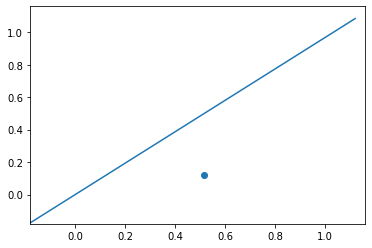

without feature  tax  and the loss is  0.0011304800467295834

Tuning random forest regressor based on boston_ptratio
--- 6.66965389251709 seconds ---
Best CV mse: 4.5957
Optimal RF meta-parameters:
{'max_features': 0.9999999999999999}



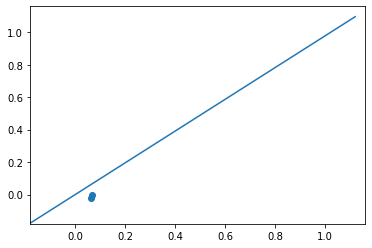

without feature  ptratio  and the loss is  2.2881915671842156e-05

Tuning random forest regressor based on boston_b
--- 6.015174865722656 seconds ---
Best CV mse: 4.6553
Optimal RF meta-parameters:
{'max_features': 0.6666666666666666}



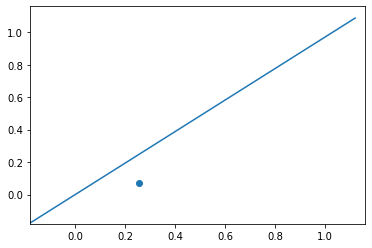

without feature  b  and the loss is  6.508210731896014e-05

Tuning random forest regressor based on boston_lstat
--- 6.485874176025391 seconds ---
Best CV mse: 80.3304
Optimal RF meta-parameters:
{'max_features': 0.6666666666666666}



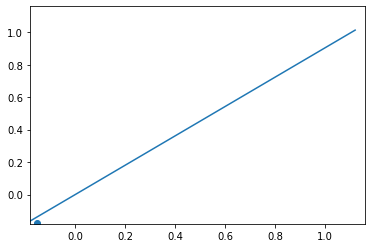

without feature  lstat  and the loss is  0.12948271984242382



In [67]:
# one example whose spearman correlation is 0.8026
name, loss = inspect('boston', 'chas', obs)

In [68]:
name

array(['ptratio'], dtype='<U7')

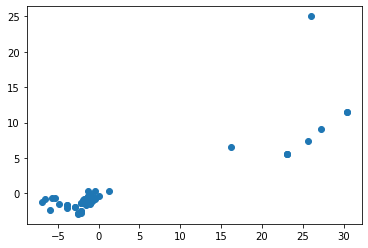

In [69]:
temp = pd.read_csv('ti_cpu.csv',)
ti_rs['df_cpu'] = temp.drop(temp.columns[0], axis=1)
temp = pd.read_csv('shap_cpu.csv',)
shap_values['df_cpu'] = temp.drop(temp.columns[0], axis=1)

# Inspect which observations are obviously out of line
plt.scatter(ti_rs['df_cpu']['vendor_amdahl'],shap_values['df_cpu']['vendor_amdahl'])
plt.show()

In [73]:
# Select them
obs2 = shap_values['df_cpu']['vendor_amdahl'][(ti_rs['df_cpu']['vendor_amdahl'] > 15) & 
                                              (shap_values['df_cpu']['vendor_amdahl']<15)].index.values

In [74]:
shap_values['df_cpu']['vendor_amdahl'][obs2]

1     5.567324
2     5.567324
3     5.567324
4     6.509407
5     7.417422
6    11.499376
7    11.499376
8     9.153020
Name: vendor_amdahl, dtype: float64

Tuning random forest regressor based on cpu_vendor_apollo
--- 4.372122287750244 seconds ---
Best CV mse: 21.4686
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



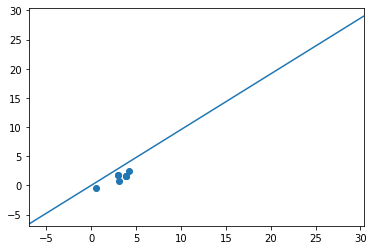

without feature  vendor_apollo  and the loss is  0.02231387677347222

Tuning random forest regressor based on cpu_vendor_basf
--- 4.282402992248535 seconds ---
Best CV mse: 21.4500
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



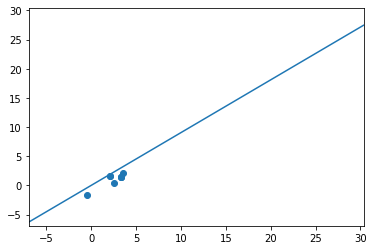

without feature  vendor_basf  and the loss is  0.07032049551094885

Tuning random forest regressor based on cpu_vendor_bti
--- 4.444378852844238 seconds ---
Best CV mse: 21.5327
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



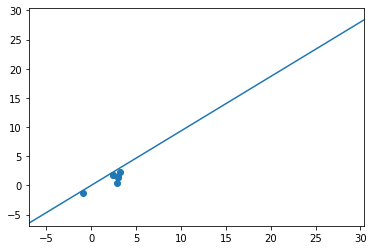

without feature  vendor_bti  and the loss is  0.03179592122082937

Tuning random forest regressor based on cpu_vendor_burroughs
--- 4.420870780944824 seconds ---
Best CV mse: 21.7517
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



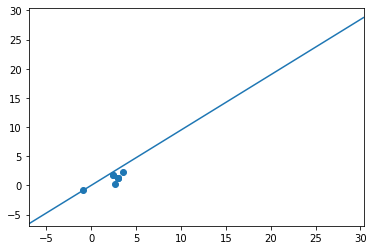

without feature  vendor_burroughs  and the loss is  0.019748156491497332

Tuning random forest regressor based on cpu_vendor_c.r.d
--- 4.724919080734253 seconds ---
Best CV mse: 21.4762
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



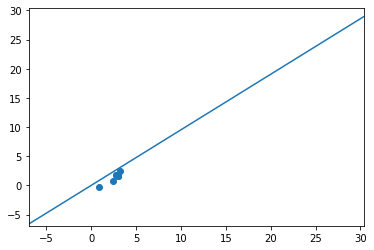

without feature  vendor_c.r.d  and the loss is  0.01645879517446758

Tuning random forest regressor based on cpu_vendor_cambex
--- 4.436353921890259 seconds ---
Best CV mse: 21.6267
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



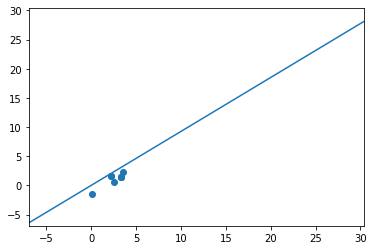

without feature  vendor_cambex  and the loss is  0.043961957960459555

Tuning random forest regressor based on cpu_vendor_cdc
--- 4.314876079559326 seconds ---
Best CV mse: 21.5592
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



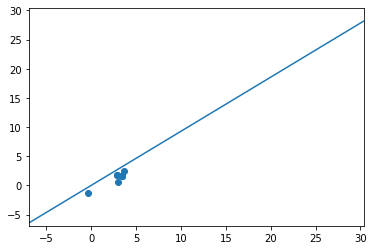

without feature  vendor_cdc  and the loss is  0.04848219008329556

Tuning random forest regressor based on cpu_vendor_dec
--- 4.508206844329834 seconds ---
Best CV mse: 21.8471
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



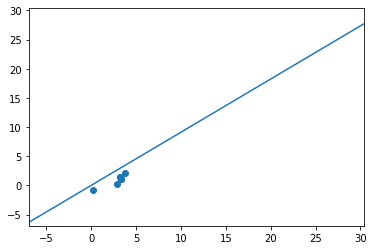

without feature  vendor_dec  and the loss is  0.0749375535169967

Tuning random forest regressor based on cpu_vendor_dg
--- 4.348153114318848 seconds ---
Best CV mse: 21.7871
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



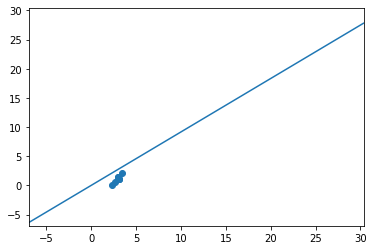

without feature  vendor_dg  and the loss is  0.06152544392195083

Tuning random forest regressor based on cpu_vendor_formation
--- 4.416612148284912 seconds ---
Best CV mse: 21.9479
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



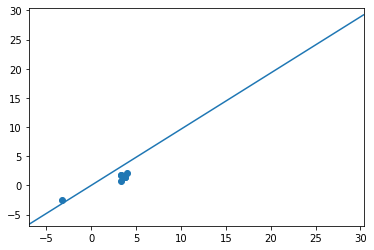

without feature  vendor_formation  and the loss is  0.016498809934914267

Tuning random forest regressor based on cpu_vendor_four-phase
--- 4.449382066726685 seconds ---
Best CV mse: 21.6930
Optimal RF meta-parameters:
{'max_features': 0.3333333333333333}



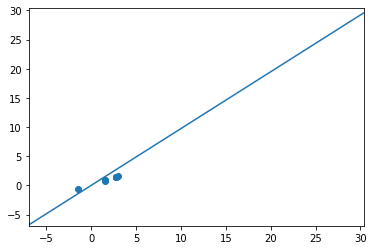

without feature  vendor_four-phase  and the loss is  0.0033135153262286695

Tuning random forest regressor based on cpu_vendor_gould
--- 4.35396671295166 seconds ---
Best CV mse: 21.9436
Optimal RF meta-parameters:
{'max_features': 0.3333333333333333}



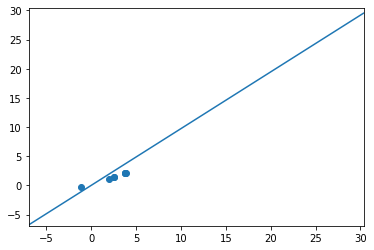

without feature  vendor_gould  and the loss is  0.006554992848844039

Tuning random forest regressor based on cpu_vendor_harris
--- 4.376297950744629 seconds ---
Best CV mse: 21.5026
Optimal RF meta-parameters:
{'max_features': 0.3333333333333333}



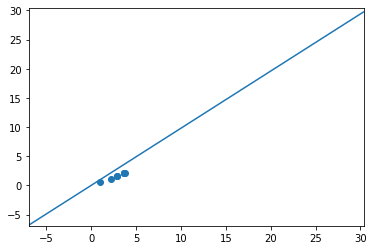

without feature  vendor_harris  and the loss is  0.0035842654475456283

Tuning random forest regressor based on cpu_vendor_honeywell
--- 4.37389612197876 seconds ---
Best CV mse: 22.6219
Optimal RF meta-parameters:
{'max_features': 0.3333333333333333}



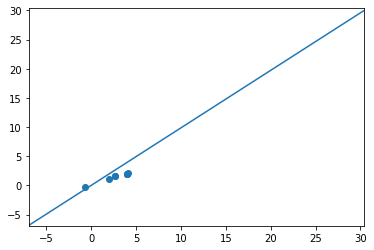

without feature  vendor_honeywell  and the loss is  0.0018577084192363945

Tuning random forest regressor based on cpu_vendor_hp
--- 4.390141010284424 seconds ---
Best CV mse: 21.9732
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



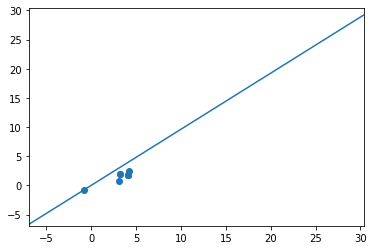

without feature  vendor_hp  and the loss is  0.01718750616979444

Tuning random forest regressor based on cpu_vendor_ibm
--- 4.31702184677124 seconds ---
Best CV mse: 21.9795
Optimal RF meta-parameters:
{'max_features': 0.3333333333333333}



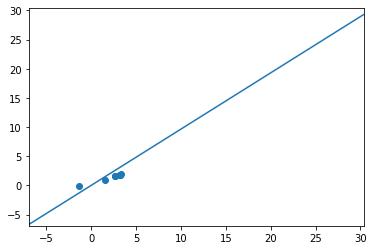

without feature  vendor_ibm  and the loss is  0.009169407624267618

Tuning random forest regressor based on cpu_vendor_ipl
--- 4.758315086364746 seconds ---
Best CV mse: 21.7542
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



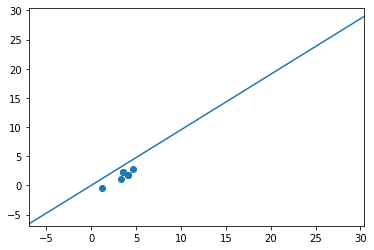

without feature  vendor_ipl  and the loss is  0.030255506530774696

Tuning random forest regressor based on cpu_vendor_magnuson
--- 4.601064920425415 seconds ---
Best CV mse: 21.8544
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



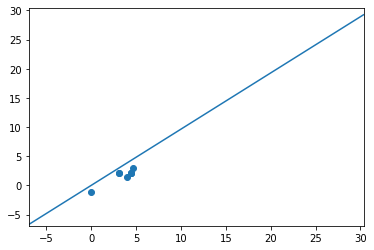

without feature  vendor_magnuson  and the loss is  0.018324083088256345

Tuning random forest regressor based on cpu_vendor_microdata
--- 4.576366901397705 seconds ---
Best CV mse: 21.6504
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



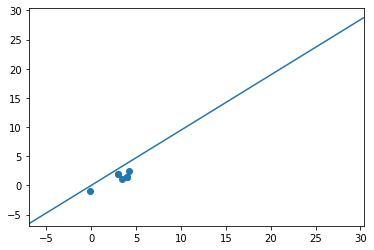

without feature  vendor_microdata  and the loss is  0.03309014513055557

Tuning random forest regressor based on cpu_vendor_nas
--- 4.59907603263855 seconds ---
Best CV mse: 21.7710
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



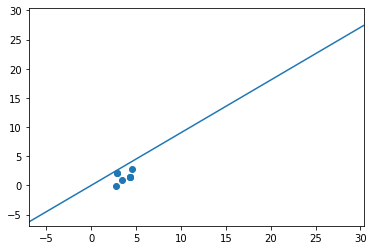

without feature  vendor_nas  and the loss is  0.13167645178107845

Tuning random forest regressor based on cpu_vendor_ncr
--- 4.505356073379517 seconds ---
Best CV mse: 21.6096
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



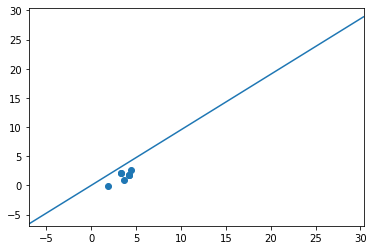

without feature  vendor_ncr  and the loss is  0.031596352432342184

Tuning random forest regressor based on cpu_vendor_nixdorf
--- 4.273545026779175 seconds ---
Best CV mse: 21.6885
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



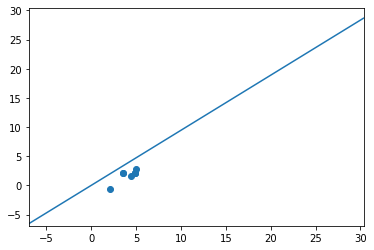

without feature  vendor_nixdorf  and the loss is  0.054465747229503064

Tuning random forest regressor based on cpu_vendor_perkin-elmer
--- 4.405951976776123 seconds ---
Best CV mse: 21.6831
Optimal RF meta-parameters:
{'max_features': 0.3333333333333333}



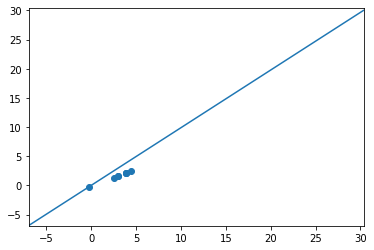

without feature  vendor_perkin-elmer  and the loss is  0.001265025638824938

Tuning random forest regressor based on cpu_vendor_prime
--- 4.417217969894409 seconds ---
Best CV mse: 21.6775
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



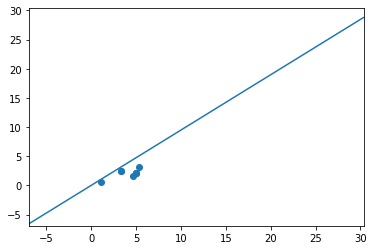

without feature  vendor_prime  and the loss is  0.04757763853190618

Tuning random forest regressor based on cpu_vendor_siemens
--- 4.3910229206085205 seconds ---
Best CV mse: 21.5331
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



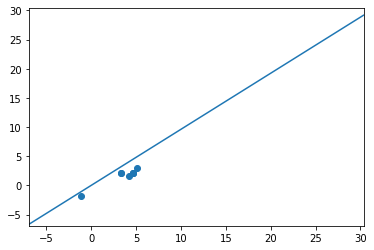

without feature  vendor_siemens  and the loss is  0.02357254802479817

Tuning random forest regressor based on cpu_vendor_sperry
--- 4.31107497215271 seconds ---
Best CV mse: 22.6128
Optimal RF meta-parameters:
{'max_features': 0.3333333333333333}



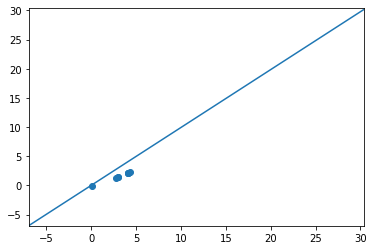

without feature  vendor_sperry  and the loss is  0.0005544337922559821

Tuning random forest regressor based on cpu_vendor_sratus
--- 4.375295162200928 seconds ---
Best CV mse: 21.8191
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



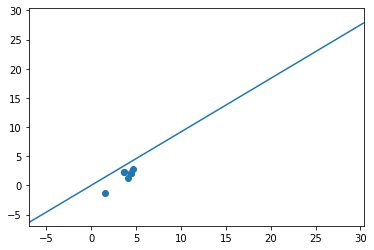

without feature  vendor_sratus  and the loss is  0.10753089740498575

Tuning random forest regressor based on cpu_vendor_wang
--- 4.420527935028076 seconds ---
Best CV mse: 21.7198
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



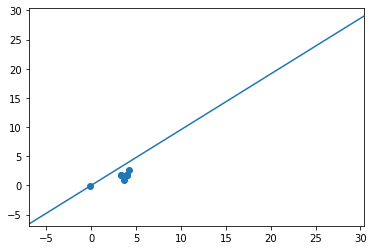

without feature  vendor_wang  and the loss is  0.02491136725649501

Tuning random forest regressor based on cpu_MYCT
--- 4.478382110595703 seconds ---
Best CV mse: 21.7369
Optimal RF meta-parameters:
{'max_features': 0.3333333333333333}



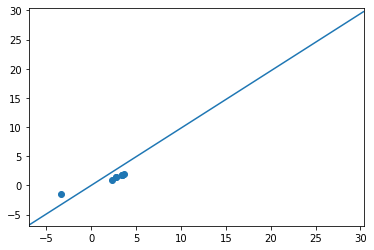

without feature  MYCT  and the loss is  0.0032316565263197502

Tuning random forest regressor based on cpu_MMIN
--- 4.300199747085571 seconds ---
Best CV mse: 21.9056
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



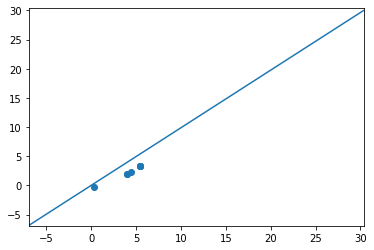

without feature  MMIN  and the loss is  0.0027905337767677243

Tuning random forest regressor based on cpu_MMAX
--- 4.282856225967407 seconds ---
Best CV mse: 22.0183
Optimal RF meta-parameters:
{'max_features': 0.3333333333333333}



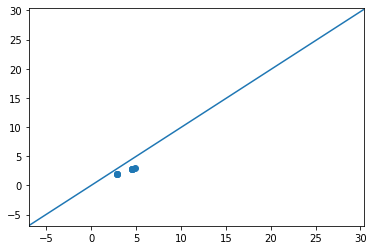

without feature  MMAX  and the loss is  0.0006726065447662095

Tuning random forest regressor based on cpu_CACH
--- 4.310875177383423 seconds ---
Best CV mse: 22.0280
Optimal RF meta-parameters:
{'max_features': 0.3333333333333333}



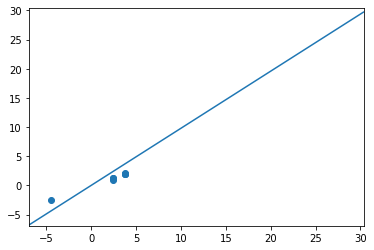

without feature  CACH  and the loss is  0.0048673410334549045

Tuning random forest regressor based on cpu_CHMIN
--- 4.3032848834991455 seconds ---
Best CV mse: 22.9861
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



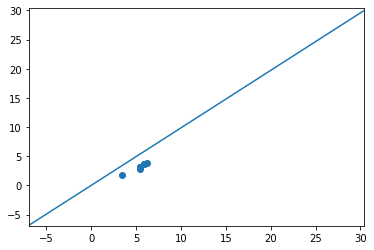

without feature  CHMIN  and the loss is  0.005338393349788836

Tuning random forest regressor based on cpu_CHMAX
--- 4.549156188964844 seconds ---
Best CV mse: 4.7547
Optimal RF meta-parameters:
{'max_features': 0.16666666666666666}



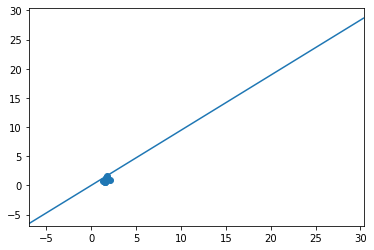

without feature  CHMAX  and the loss is  0.008243954388442495



In [75]:
# another example whose 
name2, loss2 = inspect('cpu', 'vendor_amdahl', obs2)

In [76]:
name2

array(['vendor_sperry'], dtype='<U19')

Conclusion:

1. The reason why some points are out of regression line is the properties of dummies. First, as dummies, they have fewer observations in each category; Second, other levels will affect one specific level among dummies

2. The regression line (linear and nonlinear) is compared in a plot, and spearman correlation coefficient is calculated

3. Read the paper and codes: help_functions.py, Server_GlobalImport.py is to generate GlobalImport.pickle,  GlobalImport.ipynb is to plot the Figure 3 and 4.

4. Problem: 
    - Should I keep the hyperparameter the same as when we generate ti and shap according to each dataset and optimize 'neg_root_mean_squared_error' with best 'max_features' as a control of mtry? - yes
    - Should I calculate f1 score and log loss for predicted y_test_pred from X_test (subset) and y_test(subset)? -only neg root mean squeared error
    - total importance is based on original ti and shap, right? -take the average
    
5. for each dataset global ti and shap, compute rank correlation coefficient between the two
6. plot 